**`⚠`** <font size="2">**WARNING:** Some of the code lines in this notebook may be cropped out due to display limitations. To view the entire code properly, please click on this [link](https://github.com/KonstantinosChaldaiopoulos/VideoViolenceDetection/violence-detection.ipynb) to open the notebook in nbviewer or this [link](https://colab.research.google.com/github/KonstantinosChaldaiopoulos/VideoViolenceDetection/violence-detection.ipynb) to open the notebook in Google Colab.</font>

# **Violence Detection in Movies: A Multimodal Approach**

**Overview:** With the rapid growth of video content, the efficient detection of violence in videos has become increasingly crucial for ensuring effective regulation. In this project, our main focus was on developing a multimodal classification system capable of classifying videos into violent and nonviolent. To achieve this, we used three modalities: text, audio, and image data. We explored both early fusion, where all modalities are combined and processed through one neural network, and late fusion, where individual models for each modality produce outputs that are combined to make a final decision.

In [ ]:
!pip install pyAudioAnalysis && pip install eyed3 && pip install pydub && pip install transformers && pip install setuptools-rust

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 MB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyAudioAnalysis: filename=pyAudioAnalysis-0.3.14-py3-none-any.whl size=41264374 sha256=50de498aa2bc3b8938b035ee24ac1e64d2482f097e89224a1246af88d89b6c74
  Stored in directory: /root/.cache/pip/wheels/a7/54/73/fa830689c2440d2c81ff175c60e374930ad1607a8881e0f43f
Successfully built pyAudioAnalysis
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 96.4 MB/s eta 0:00:00


## **1. Import all the necessary modules**

**Briefly:** `warnings` module handles warning messages, `numpy` is used for numerical arrays, `google.colab` mounts Google Drive, changing the working directory to "mdml-run-env." Custom modules `_model`, `_dataset`, and `_utils` contain essential classes and functions for the multimodal classification system.

In [ ]:
import warnings
import numpy as np
from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/MyDrive/mdml-run-env

from _model import *
from _dataset import *
from _utils import *

Mounted at /content/drive
/content/drive/MyDrive/mdml-run-env


## **2. Set up Device and Dataset Path**

We configure the device to use either the GPU (CUDA) if it is available or the CPU for computations. This enables faster processing of deep learning operations if a compatible GPU is present. Next, we set NumPy's print options to suppress scientific notation when displaying arrays, ensuring better readability of numeric data. To avoid displaying certain types of warnings, we use warnings.filterwarnings() to ignore UserWarnings and prevent them from cluttering the output. Finally, we define the variable path to store the path to the movie dataset. This path is essential for loading and accessing the dataset during various stages of the project.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore", category=UserWarning)

path = "/content/drive/MyDrive/DATASETS/movie-dataset"

## **3. Load Dataset and Multimodal Feature Extraction**

We create a MovieDataset object named ds to handle the movie dataset. The dataset is set up to utilize the specified device for computation (either the GPU or CPU). The path variable, which was defined earlier, is passed to the dataset, allowing it to access and process the movie dataset from the specified location.

To load the data and extract its features, the prepare_data() method of the MovieDataset class is called. This method processes the audio, image, and text data within the dataset. The audio data is resampled to a sample_rate of 16000 Hz, ensuring consistency across all audio files. Finally, the features of each modality, audio_data, image_data, and text_data, are saved and ready for use.

In [ ]:
ds = MovieDataset(device, path, sample_rate=16000, metric="std")
audio_data, image_data, text_data = ds.prepare_data()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## **4. Perform Late Fusion Classification**

We implement the late fusion technique for classification. Late fusion involves combining the outputs of separate classifiers, each trained on one specific modality (audio, image, or text), to make a final decision. The process starts by training individual classifiers for each modality using their corresponding preprocessed data. These classifiers are designed to learn patterns and features unique to their respective modalities. Once the classifiers are trained, we pass new unseen data through each of them to obtain their predictions.

### **4.1. Audio Classification Model**

In the Late Fusion approach for audio classification, we use a Support Vector Machine (SVM) classifier. To achieve this, we instantiate an instance of the TRClassifier class (traditional classifier), providing it with the necessary inputs. These inputs include the audio_data, which is obtained from the MovieDataset and contains the preprocessed audio features and labels for training, validation, and testing. Additionally, we pass the ds.get_feature_names() function as input to specify the names of the audio features used for training the SVM classifier. In this case, the number of selected features is set to num_features=7, indicating that we are using seven relevant audio features to distinguish between violent and non-violent audio samples.

The TRClassifier class is designed to handle machine learning classification tasks, and in this case, it is configured to use the SVM classifier with the specified features. During training, the SVM classifier learns to differentiate between violent and non-violent audio samples based on the selected audio features. We then evaluate the performance of the SVM classifier on both the validation and test datasets, obtaining the validation accuracy (audio_val_acc) and the test accuracy (audio_test_acc) as performance metrics. These accuracies reflect how well the SVM classifier can classify videos into the "violence" and "non-violence" categories based on their audio features.

In [ ]:
aSVM = TRClassifier(*audio_data, ds.get_feature_names(), num_features=7, classifier="svm", scaler=None)
audio_val_acc, audio_test_acc = aSVM.run()

Validation Accuracy: 0.7
Test Accuracy: 0.7


### **4.2. Text Classification Model**

In the Late Fusion approach for text classification, we use a Support Vector Machine (SVM) classifier. To implement this, we instantiate the TRClassifier class with the appropriate inputs. For text classification, the input text_data is obtained from the MovieDataset and contains the preprocessed text embeddings and labels for training, validation, and testing. The TRClassifier class is specifically designed for machine learning classification tasks and can be configured to use different classifiers. In this case, we set the classifier to SVM and specify num_features=10, indicating that we utilize ten relevant text embeddings to distinguish between "violent" and "non-violent" samples.

During training, the SVM classifier learns to discern patterns and features specific to each class based on the selected text embeddings. We then evaluate the performance of the SVM classifier on both the validation and test datasets, obtaining the validation accuracy (text_val_acc) and test accuracy (text_test_acc) as performance metrics. These accuracies represent how well the SVM classifier can classify videos into the "violence" and "non-violence" categories based on their text embeddings.

In [ ]:
tSVM = TRClassifier(*text_data, None, num_features=10, classifier="svm", scaler=None)
text_val_acc, text_test_acc = tSVM.run()

Validation Accuracy: 0.7666666666666667
Test Accuracy: 0.7666666666666667


The text classification model outperformed the audio classification model with slightly higher validation and test accuracies (0.7667) compared to the audio's (0.7). Text-based features showed to be a bit more informative in distinguishing between violent and non-violent videos in this dataset.

### **4.3. Image Classification Model**

We implement the image classification using a Neural Network (NN) classifier. We create an instance of the NNClassifier class, providing it with the necessary inputs. The inputs include the image_data obtained from the MovieDataset, which contains the preprocessed image features and labels for training, validation, and testing. We set the number of training epochs to 20, the learning rate to 0.00001, and the weight decay to 0.05. The device parameter is specified as "cuda" if available, otherwise "cpu", indicating whether the computation should be done on the GPU or CPU.

The NNClassifier class is designed to handle image classification tasks using a neural network architecture. During training, the neural network learns to extract features from the images and classify them into the "violence" and "non-violence" categories. After training, we evaluate the performance of the image classifier on both the validation and test datasets, obtaining the validation accuracy (image_val_acc) and the test accuracy (image_test_acc) as performance metrics. These accuracies reflect how well the neural network model can classify videos into different classes based on their image features.

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 245MB/s]
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 57.6MB/s]
Validating: 100%|██████████| 4/4 [02:06<00:00, 31.61s/it]


Epoch: 1, Validation Accuracy: 66.67 %, Validation Precision: 69.84 %, Validation Recall: 66.67 %, Validation F1-score: 65.28 %
Model saved at epoch 1 with Validation Accuracy: 0.67%


Validating: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


Epoch: 2, Validation Accuracy: 73.33 %, Validation Precision: 73.76 %, Validation Recall: 73.33 %, Validation F1-score: 73.21 %
Model saved at epoch 2 with Validation Accuracy: 0.73%


Validating: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch: 3, Validation Accuracy: 83.33 %, Validation Precision: 87.50 %, Validation Recall: 83.33 %, Validation F1-score: 82.86 %
Model saved at epoch 3 with Validation Accuracy: 0.83%


Validating: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Epoch: 4, Validation Accuracy: 73.33 %, Validation Precision: 82.61 %, Validation Recall: 73.33 %, Validation F1-score: 71.29 %


Validating: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch: 5, Validation Accuracy: 86.67 %, Validation Precision: 87.33 %, Validation Recall: 86.67 %, Validation F1-score: 86.61 %
Model saved at epoch 5 with Validation Accuracy: 0.87%


Validating: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch: 6, Validation Accuracy: 90.00 %, Validation Precision: 91.67 %, Validation Recall: 90.00 %, Validation F1-score: 89.90 %
Model saved at epoch 6 with Validation Accuracy: 0.90%


Validating: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Epoch: 7, Validation Accuracy: 90.00 %, Validation Precision: 91.67 %, Validation Recall: 90.00 %, Validation F1-score: 89.90 %
Model saved at epoch 7 with Validation Accuracy: 0.90%


Validating: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Epoch: 8, Validation Accuracy: 90.00 %, Validation Precision: 91.67 %, Validation Recall: 90.00 %, Validation F1-score: 89.90 %
Model saved at epoch 8 with Validation Accuracy: 0.90%


Validating: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch: 9, Validation Accuracy: 90.00 %, Validation Precision: 91.67 %, Validation Recall: 90.00 %, Validation F1-score: 89.90 %
Model saved at epoch 9 with Validation Accuracy: 0.90%


Validating: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch: 10, Validation Accuracy: 90.00 %, Validation Precision: 91.67 %, Validation Recall: 90.00 %, Validation F1-score: 89.90 %
Model saved at epoch 10 with Validation Accuracy: 0.90%


Validating: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch: 11, Validation Accuracy: 83.33 %, Validation Precision: 87.50 %, Validation Recall: 83.33 %, Validation F1-score: 82.86 %


Validating: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


Epoch: 12, Validation Accuracy: 83.33 %, Validation Precision: 87.50 %, Validation Recall: 83.33 %, Validation F1-score: 82.86 %


Validating: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Epoch: 13, Validation Accuracy: 90.00 %, Validation Precision: 91.67 %, Validation Recall: 90.00 %, Validation F1-score: 89.90 %
Model saved at epoch 13 with Validation Accuracy: 0.90%


Validating: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch: 14, Validation Accuracy: 96.67 %, Validation Precision: 96.88 %, Validation Recall: 96.67 %, Validation F1-score: 96.66 %
Model saved at epoch 14 with Validation Accuracy: 0.97%


Validating: 100%|██████████| 4/4 [00:05<00:00,  1.27s/it]


Epoch: 15, Validation Accuracy: 90.00 %, Validation Precision: 91.67 %, Validation Recall: 90.00 %, Validation F1-score: 89.90 %


Validating: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Epoch: 16, Validation Accuracy: 80.00 %, Validation Precision: 85.71 %, Validation Recall: 80.00 %, Validation F1-score: 79.17 %


Validating: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


Epoch: 17, Validation Accuracy: 63.33 %, Validation Precision: 78.85 %, Validation Recall: 63.33 %, Validation F1-score: 57.64 %


Validating: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch: 18, Validation Accuracy: 86.67 %, Validation Precision: 89.47 %, Validation Recall: 86.67 %, Validation F1-score: 86.43 %


Validating: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch: 19, Validation Accuracy: 86.67 %, Validation Precision: 89.47 %, Validation Recall: 86.67 %, Validation F1-score: 86.43 %


Validating: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch: 20, Validation Accuracy: 93.33 %, Validation Precision: 94.12 %, Validation Recall: 93.33 %, Validation F1-score: 93.30 %


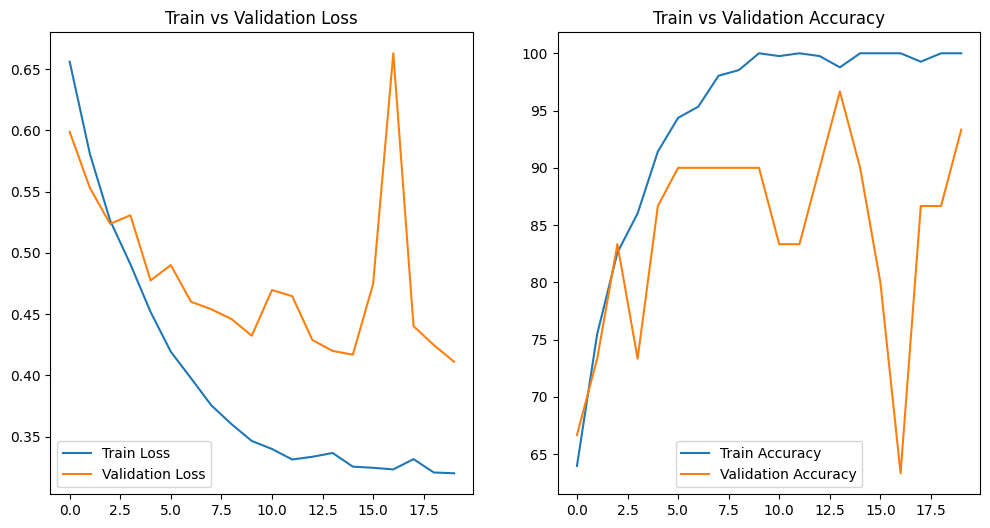

Testing: 100%|██████████| 4/4 [02:08<00:00, 32.07s/it]

Test Accuracy: 76.67 %, Test Precision: 76.79 %, Test Recall: 76.67 %, Test F1-score: 76.64 %


In [ ]:
iNN = NNClassifier(*image_data, epochs=20, lr=0.00001, wd=0.05, device=device)
image_val_acc, image_test_acc = iNN.run()

The image classification results show that the model achieved a test accuracy of 76.67%, which indicates that it can correctly classify approximately 76.67% of the test video samples into the correct categories (violent or non-violent) based on their image features. The training and validation curves also indicate that the model's performance improved during the training process, with the validation accuracy reaching as high as 96.67% at epoch 14. This suggests that the model is learning relevant patterns from the image data and generalizing well to unseen samples.

## **5. Perform Early Fusion Classification**

In the Early Fusion approach, we aim to achieve multi-modal classification by combining the information from different modalities (audio, image, and text) at an early stage of the model architecture. To enable this fusion, we create an instance of the MultiMovieDataset class, passing the preprocessed audio_data, image_data, and text_data as inputs. This dataset is designed to handle multi-modal data and serves as an intermediate step to merge the features from different modalities.

The MultiMovieDataset class organizes the data from each modality in a way that allows easy access during the fusion process. By creating this dataset, we prepare the necessary input for the multi-modal fusion step, facilitating the combination of information from audio, image, and text modalities into a unified model for the final classification.

The fused data, stored in multi_data, consists of integrated features from all modalities, making it possible to train a unified classifier that leverages the strengths of each individual modality. This multi-modal fusion approach aims to improve overall performance and enhance the model's ability to classify videos into "violence" and "non-violence" categories based on features extracted from multiple sources.

In [ ]:
mds = MultiMovieDataset(audio_data, image_data, text_data, exists=False)
multi_data = mds.prepare_multidata()

We perform multi-modal classification using a Neural Network (NN) classifier. To achieve this, we create an instance of the MNNClassifier class, providing it with the necessary inputs from multi_data. The multi_data contains preprocessed data that combines features from all modalities (audio, image, and text) to enable multi-modal fusion. The MNNClassifier class is specifically designed to handle multi-modal classification tasks using a neural network architecture. During training, the neural network learns to extract informative patterns and features from the integrated data, allowing it to classify videos into the "violence" and "non-violence" categories based on the combined information from audio, image, and text.

We configure the NN classifier with specific hyperparameters for training. The number of training epochs is set to 25, indicating the number of times the model will see the entire training dataset during training. The learning rate is set to 0.00001, controlling the step size at each iteration during optimization, and the weight decay is set to 0.0, which helps control overfitting. The device parameter is specified as "cuda" if a compatible GPU is available for computation, otherwise it will use "cpu". This choice allows us to utilize the power of GPU acceleration for faster training if possible.

After training the multi-modal neural network classifier, we evaluate its performance on the test dataset to obtain the test accuracy (multi_test_acc). This accuracy metric reflects how well the integrated model can classify videos into different classes based on the combined features from all modalities, showcasing the effectiveness of the multi-modal fusion approach.

Training epoch 1: 100%|██████████| 51/51 [00:59<00:00,  1.16s/it]

Train Loss: 0.690027, Accuracy: 57.35%


Val Loss: 0.683370, Accuracy: 66.67%
Model saved at epoch 1 with Accuracy: 66.67%


Training epoch 2: 100%|██████████| 51/51 [00:59<00:00,  1.16s/it]

Train Loss: 0.672118, Accuracy: 70.83%


Val Loss: 0.657513, Accuracy: 70.00%
Model saved at epoch 2 with Accuracy: 70.00%


Training epoch 3: 100%|██████████| 51/51 [00:59<00:00,  1.16s/it]

Train Loss: 0.640520, Accuracy: 74.02%


Val Loss: 0.642442, Accuracy: 66.67%


Training epoch 4: 100%|██████████| 51/51 [01:00<00:00,  1.19s/it]

Train Loss: 0.606680, Accuracy: 77.94%


Val Loss: 0.616670, Accuracy: 73.33%
Model saved at epoch 4 with Accuracy: 73.33%


Training epoch 5: 100%|██████████| 51/51 [01:00<00:00,  1.18s/it]

Train Loss: 0.583895, Accuracy: 77.70%


Val Loss: 0.582106, Accuracy: 70.00%


Training epoch 6: 100%|██████████| 51/51 [01:00<00:00,  1.19s/it]

Train Loss: 0.549627, Accuracy: 82.35%


Val Loss: 0.588061, Accuracy: 70.00%


Training epoch 7: 100%|██████████| 51/51 [01:00<00:00,  1.19s/it]

Train Loss: 0.534438, Accuracy: 81.13%


Val Loss: 0.572460, Accuracy: 76.67%
Model saved at epoch 7 with Accuracy: 76.67%


Training epoch 8: 100%|██████████| 51/51 [01:00<00:00,  1.19s/it]

Train Loss: 0.506744, Accuracy: 85.05%


Val Loss: 0.563898, Accuracy: 76.67%
Model saved at epoch 8 with Accuracy: 76.67%


Training epoch 9: 100%|██████████| 51/51 [01:01<00:00,  1.20s/it]

Train Loss: 0.483139, Accuracy: 85.78%


Val Loss: 0.548627, Accuracy: 76.67%
Model saved at epoch 9 with Accuracy: 76.67%


Training epoch 10: 100%|██████████| 51/51 [00:59<00:00,  1.17s/it]

Train Loss: 0.470318, Accuracy: 86.76%


Val Loss: 0.616755, Accuracy: 66.67%


Training epoch 11: 100%|██████████| 51/51 [00:58<00:00,  1.14s/it]

Train Loss: 0.447932, Accuracy: 88.48%


Val Loss: 0.531764, Accuracy: 83.33%
Model saved at epoch 11 with Accuracy: 83.33%


Training epoch 12: 100%|██████████| 51/51 [00:59<00:00,  1.16s/it]

Train Loss: 0.428357, Accuracy: 91.91%


Val Loss: 0.548562, Accuracy: 80.00%


Training epoch 13: 100%|██████████| 51/51 [00:59<00:00,  1.16s/it]

Train Loss: 0.415021, Accuracy: 93.38%


Val Loss: 0.542584, Accuracy: 73.33%


Training epoch 14: 100%|██████████| 51/51 [00:58<00:00,  1.15s/it]

Train Loss: 0.403207, Accuracy: 93.38%


Val Loss: 0.538037, Accuracy: 80.00%


Training epoch 15: 100%|██████████| 51/51 [00:59<00:00,  1.16s/it]

Train Loss: 0.385291, Accuracy: 95.34%


Val Loss: 0.555899, Accuracy: 83.33%
Model saved at epoch 15 with Accuracy: 83.33%


Training epoch 16: 100%|██████████| 51/51 [00:58<00:00,  1.15s/it]

Train Loss: 0.371287, Accuracy: 97.06%


Val Loss: 0.606174, Accuracy: 66.67%


Training epoch 17: 100%|██████████| 51/51 [00:59<00:00,  1.17s/it]

Train Loss: 0.362309, Accuracy: 97.06%


Val Loss: 0.527490, Accuracy: 76.67%


Training epoch 18: 100%|██████████| 51/51 [00:59<00:00,  1.17s/it]

Train Loss: 0.353949, Accuracy: 97.55%


Val Loss: 0.808709, Accuracy: 50.00%


Training epoch 19: 100%|██████████| 51/51 [01:00<00:00,  1.19s/it]

Train Loss: 0.366601, Accuracy: 95.34%


Val Loss: 0.516161, Accuracy: 76.67%


Training epoch 20: 100%|██████████| 51/51 [01:01<00:00,  1.20s/it]

Train Loss: 0.352019, Accuracy: 97.06%


Val Loss: 0.477863, Accuracy: 83.33%
Model saved at epoch 20 with Accuracy: 83.33%


Training epoch 21: 100%|██████████| 51/51 [01:00<00:00,  1.20s/it]

Train Loss: 0.333799, Accuracy: 98.77%


Val Loss: 0.510068, Accuracy: 80.00%


Training epoch 22: 100%|██████████| 51/51 [01:00<00:00,  1.19s/it]

Train Loss: 0.328858, Accuracy: 99.02%


Val Loss: 0.470641, Accuracy: 83.33%
Model saved at epoch 22 with Accuracy: 83.33%


Training epoch 23: 100%|██████████| 51/51 [01:00<00:00,  1.19s/it]

Train Loss: 0.327786, Accuracy: 99.02%


Val Loss: 0.494641, Accuracy: 80.00%


Training epoch 24: 100%|██████████| 51/51 [00:59<00:00,  1.17s/it]

Train Loss: 0.326600, Accuracy: 99.02%


Val Loss: 0.477802, Accuracy: 80.00%


Training epoch 25: 100%|██████████| 51/51 [00:59<00:00,  1.17s/it]

Train Loss: 0.325655, Accuracy: 99.02%


Val Loss: 0.475625, Accuracy: 80.00%


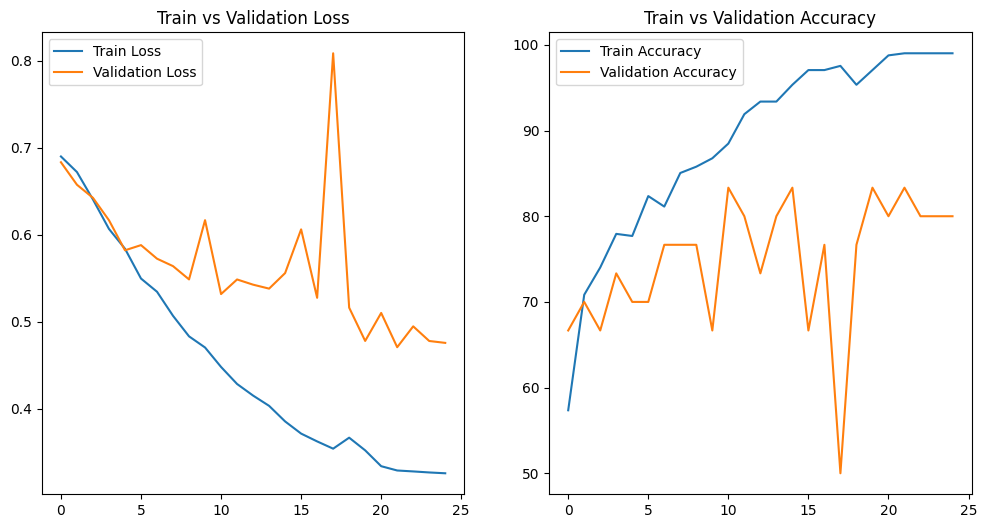

Testing: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

Test Accuracy: 80.00 %, Test Precision: 80.54 %, Test Recall: 80.00 %, Test F1-score: 79.91 %


In [ ]:
mdMNN = MNNClassifier(*multi_data, epochs=25, lr=0.00001, wd=0.0, device=device)
multi_test_acc = mdMNN.run()

The multimodal classification model, combining audio, image, and text data, achieved a test accuracy of 80.00%. This indicates that the model can accurately classify approximately 80.00% of the test video samples into the correct categories (violent or non-violent) based on their features from different modalities. The model's performance improved during training, reaching a high validation accuracy of 83.33% at epoch 11. The results indicate effective classification and good generalization to unseen data.

## **6. Calculate and Compare Accuracies**

We first calculate the late fusion accuracy, which takes into account the performance of each classifier on the best-performing validation dataset. We use the late_fuse function to compute this accuracy. This function receives two tuples as input: the first tuple contains the validation accuracies for each modality (audio, text, and image), while the second tuple contains the corresponding test accuracies for each modality. The late fusion accuracy is determined by weighting each test accuracy with its corresponding validation accuracy and then summing them up.

After calculating the late fusion accuracy, we print it to the console in percentage format with two decimal places. Similarly, we print the early fusion accuracy, which represents the performance of the multimodal classifier when all modalities' features are combined together before training and classification. By comparing these fusion accuracies, we can evaluate the benefits of combining multiple modalities in the classification task and assess the effectiveness of our multimodal approach.

In [ ]:
late_fusion_acc = late_fuse((audio_val_acc, text_val_acc, image_val_acc), (audio_test_acc, text_test_acc, image_test_acc))
print("Late Fusion Accuracy: {:.2f} %".format(late_fusion_acc))
print("Early Fusion Accuracy: {:.2f} %".format(multi_test_acc))

Late Fusion Accuracy: 0.75 %
Early Fusion Accuracy: 0.80 %


The Early Fusion method achieves a higher accuracy (0.80%) compared to the Late Fusion method (0.75%) in combining multiple modalities for classification. This suggests that fusing the modalities early, by combining their features before training, leads to better performance in this scenario.